# Imports

In [1]:
import math
import os
import numpy as np

import torch.utils.data
import torch.nn.functional as F

import sys

sys.path.append("../")

from models import cifar10_model

# Hyperparameters

In [2]:
# Conformal Prediction
ALPHA = 0.1
TEMP = 10.0
BIAS = 0.1
# $l_2$ robustness radius
EPSILON = 0.03
BATCH_SIZE = 64

# Loading the dataset

Here we load the multiple data splits and ensure that the model is not calibrated or tested on unseen data.

In [3]:
from utils.utils_transforms import get_data
from utils.utils_transforms import LIPCONSTANT_PREPROCESS_DATASET

train_dataset, val_dataset, cal_dataset, test_dataset, data_trfm = get_data(
    "cifar10",
    normalize=True,
    augmentations_prob=[],
    p_augmentations_imgs=0,
    p_augmentations_mix=0,
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
cal_loader = torch.utils.data.DataLoader(
    cal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
lipconstant = LIPCONSTANT_PREPROCESS_DATASET["cifar10"]
attack_radius = EPSILON * lipconstant

Loading dataset with n_train = 50000, n_val = 500, n_cal = 4500, n_test = 5000


# Load the trained model

We use a ResNet18 like architecture with Gradient Norm Preserving (GNP) layers from the orthogonium library of Boissin et al. 2025.

In [4]:
model = cifar10_model(num_classes=10)
if torch.cuda.device_count() > 1:
    device = "cuda:0"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.load_state_dict(
    torch.load("../model_weights/CNN_cifar10.pth", map_location=device)
)

/tmp/ipykernel_3234559/2304290003.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../model_weights/CNN_cifar10.pth", map_location=devic

<All keys matched successfully>

# Efficient Certifiable Robust Conformal Prediction

Using Lipschitz constrained networks we are able to efficiently compute prediction sets which verify the following definition :

<div style="text-align: center;">
    <img src="../ressources/definition.png" alt="RCP definition" width="570"/>
</div>

### Calibrating the model

We use a standard vanilla CP conformal calibration procedure with a finite-sample correction. We use the following conformal score:

$$s(x,y) = \sigma \left(\frac{f_y(x) - b}{t} \right)$$

where $f_y(x)$ is the logit for the y-th class, $\sigma$ is the sigmoid function, $b$ and $t$ are the bias and temperature hyperparameters of the score.

In [5]:
from deel.lip_rcp.robust_ps import calibrate_lac_sigmoid, evaluate_lac_sigmoid

q_hat = calibrate_lac_sigmoid(
    model, cal_loader, alpha=ALPHA, temp=TEMP, bias=BIAS, device=device, num_batches=100
)

71it [00:04, 16.07it/s]


This function calibrates the model using a Conformal Risk Control approach with a binary loss, which is equivalent to the Split Conformal Prediction for classification setting.

### Computing the Robust CP sets

Given the known Lipschitz constant of the model we compute a very simple 'worst-case' conformal score variation which ensures the finite sample validity of the robust prediction set.

In [6]:
for i, data in enumerate(test_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    logits = model(inputs)

    # Compute the conformal scores
    vanilla_score = F.sigmoid((logits - BIAS) / TEMP)
    robust_score = F.sigmoid((logits + attack_radius - BIAS) / TEMP)
    # Compute the prediction sets
    vanilla_ps = vanilla_score >= q_hat
    robust_ps = robust_score >= q_hat
    break

We efficiently compute the robust predictions sets for the elements of this batch of test samples using the Lipschitz constraint of the trained model. 

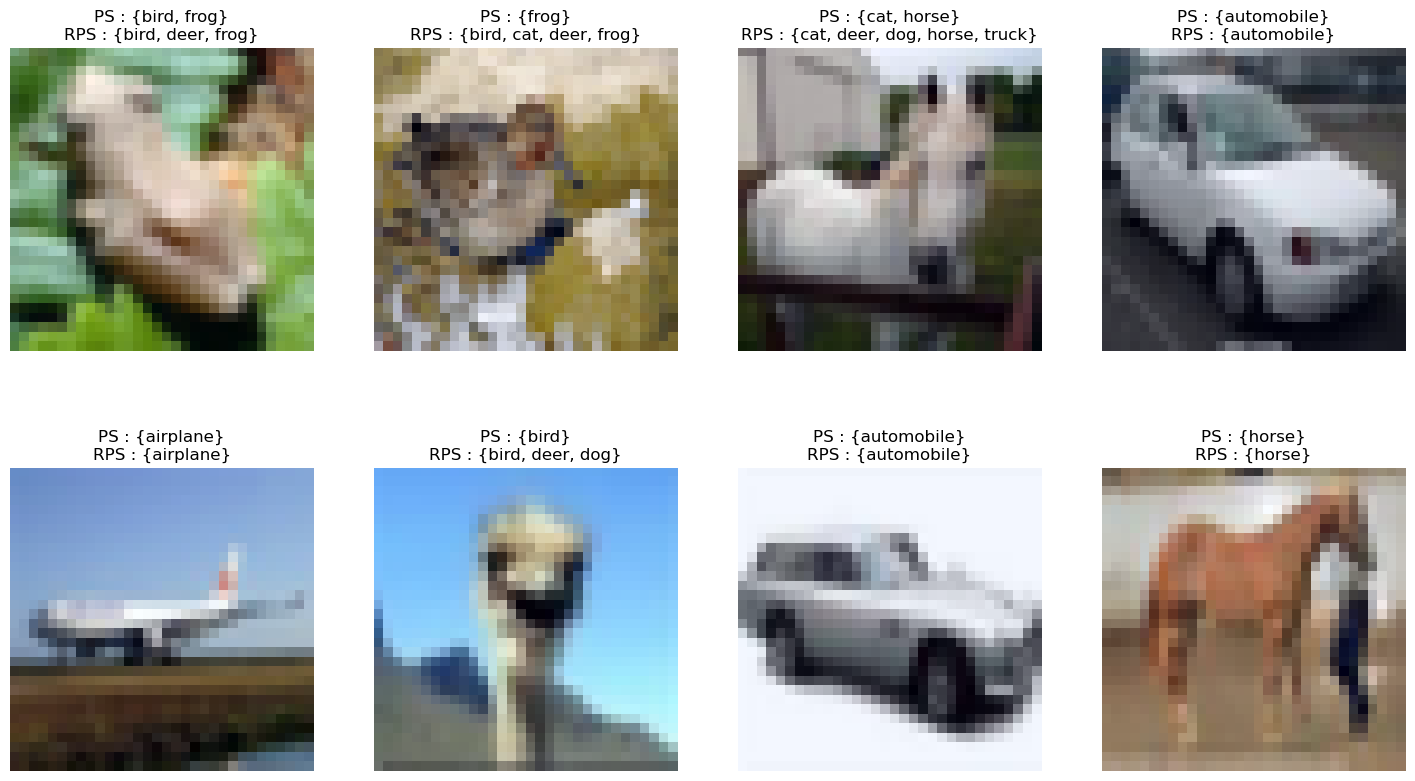

In [7]:
import matplotlib.pyplot as plt
from utils.utils_notebooks import plot_banner, classes

plt.figure(figsize=(18, 10))

plot_banner(inputs, vanilla_ps, robust_ps, classes)

We distinguish the classical conformal Prediction Set (PS) and the robust Prediction Set (RPS) by the finite sample guarantees they provide as the RPS guarantees are stronger in adversarial conditions. Importantly we aim for the conservative prediction sets to be as close as possible than the original "non-robust" vanilla prediction sets to maximise their informativeness.

In [8]:
vcoverage, vss = evaluate_lac_sigmoid(
    model, test_loader, TEMP, BIAS, q_hat, 0, device, num_batches=100
)
rcoverage, rss = evaluate_lac_sigmoid(
    model, test_loader, TEMP, BIAS, q_hat, attack_radius, device, num_batches=100
)

2it [00:00, 14.98it/s]

79it [00:04, 17.16it/s]
79it [00:05, 14.18it/s]


In [9]:
print(
    f"Vanilla CP empirical coverage: {vcoverage} / Robust CP empirical coverage: {rcoverage}"
)
print(f"Vanilla CP empirical size: {vss} / Robust CP empirical size: {rss}")

Vanilla CP empirical coverage: 0.903 / Robust CP empirical coverage: 0.9662
Vanilla CP empirical size: 1.4802 / Robust CP empirical size: 2.2564
